<a href="https://colab.research.google.com/github/ghoreishi/Sod_problem/blob/main/Sod_1D_Euler_WEPINNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import sympy as sp
from torch import nn
import matplotlib.pyplot as plt
# torch.use_deterministic_algorithms(True)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Define domain

In [2]:
nx = 100
nt = 20

x = np.linspace(0, 1, nx, endpoint=True, retstep=False, dtype=None, axis=0)
# x = np.arange(0,1.05,0.05)
# x = np.round(x,2)
print(x)
t = np.linspace(0, 0.2, nt)

gama = 1.4
epsolin_1 = 1
epsilon_2 = 0.01

Adam_it = 9000
LBFGS_it = 1000

write_step = 2000

[0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.5959596
 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071 0.71717172
 0.72727273 0.73737374 0.74747475 0.75757576 0.76767677 0.77777778
 0.78787879 0.7979798  0.80808081 0.81818182 0.82828283 0.83838384
 0.84848485 0.85858586 0.86868687 0.87878788 0.88888889 0.89898

Definition of neural network architecture

In [3]:
class NeuralNet(nn.Module):

    def __init__(self , Layers , activator = nn.Tanh()):

        super(NeuralNet , self).__init__()

        # Main Neural Network
        # Input Layer
        self.model = nn.ModuleList( [nn.Linear(Layers[0],Layers[1])])

        # Other Layers
        for i in range(1,len(Layers)-1):
            self.model.append(activator)
            self.model.append(nn.Linear(Layers[i],Layers[i+1]))


        # Weight Initializer
        self.model.apply(self.init_weights)

        self.model = self.model.to(device)

    def forward(self , x):  # When Calling The Neural Net
        for layer in self.model:
            x = layer(x)
        return x

    def init_weights(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_normal_(m.weight , gain = 5/3)

Define AD

In [4]:
def jacv_gen(x , direc):
    jacv = torch.zeros(x.shape , device = device)
    jacv[:,direc] = 1
    return jacv

### Define Euler function

In [5]:
from torch.autograd.functional import jvp

def Euler_Equation_1D(model , xcolloc, gama, epsilon_2):

    global landa, pointwise_Residual, MSE_Euler_Res, diff_Div_u, diff_Div_epsilon2, res_dmomentum_flux_dx

    rho_u_p = model(xcolloc)
    rho = rho_u_p[:,0]
    u = rho_u_p[:,1]
    p = rho_u_p[:,2]
    # e = rho_u_p_e[:,3]

    d_dx = jvp(model, xcolloc, v = jacv_gen(xcolloc,1), create_graph=True)[1]
    Div_rho = d_dx[:,0]
    Div_u = d_dx[:,1]
    Div_p = d_dx[:,2]
    # Div_e = d_dx[:,3]

    continuity_temporal = lambda x: (model(x)[:,0])
    continuity_flux = lambda x: (model(x)[:,0]) * (model(x)[:,1])
    dcontinuity_temporal_dt = jvp(continuity_temporal, xcolloc, v = jacv_gen(xcolloc , 0) , create_graph=True )[1]
    dcontinuity_flux_dx = jvp(continuity_flux, xcolloc, v = jacv_gen(xcolloc , 1) , create_graph=True )[1]

    momentum_temporal = lambda x: (model(x)[:,0]) * (model(x)[:,1])
    momentum_flux = lambda x: (model(x)[:,0]) * ((model(x)[:,1])**2) + (model(x)[:,2]) / gama
    dmomentum_temporal_dt = jvp(momentum_temporal, xcolloc, v = jacv_gen(xcolloc , 0) , create_graph=True )[1]
    dmomentum_flux_dx = jvp(momentum_flux, xcolloc, v = jacv_gen(xcolloc , 1) , create_graph=True )[1]

    energy_temporal = lambda x: ((model(x)[:,2]) / (gama - 1) + (gama * (model(x)[:,0]) * (model(x)[:,1])**2) / 4)
    energy_flux = lambda x: ((model(x)[:,2]) / (gama - 1) + \
                            (gama * (model(x)[:,0]) * (model(x)[:,1])**2) / 4) * (model(x)[:,1]) + \
                            (model(x)[:,2]) * (model(x)[:,1])
    denergy_temporal_dt = jvp(energy_temporal, xcolloc, v = jacv_gen(xcolloc , 0) , create_graph=True )[1]
    denergy_flux_dx = jvp(energy_flux, xcolloc, v = jacv_gen(xcolloc , 1) , create_graph=True )[1]


    # landa = 1 / (epsilon_2 * (abs(Div_u) - Div_u) + 1)
    landa = 1

    res_continuity = landa * (dcontinuity_temporal_dt + dcontinuity_flux_dx)
    res_dmomentum_flux_dx = landa * (dmomentum_temporal_dt + dmomentum_flux_dx)
    res_denergy_flux_dx = landa * (denergy_temporal_dt + denergy_flux_dx)

    pointwise_Residual = res_continuity + res_dmomentum_flux_dx + res_denergy_flux_dx

    loss = nn.MSELoss()

    MSE_Euler_Res = loss(res_continuity, torch.zeros_like(res_continuity)) + \
                    loss(res_dmomentum_flux_dx, torch.zeros_like(res_dmomentum_flux_dx)) + \
                    loss(res_denergy_flux_dx, torch.zeros_like(res_denergy_flux_dx))

    return MSE_Euler_Res

Interior points

In [6]:
import itertools
X_colloc = torch.tensor(list(itertools.product(t[1:],x[1:-1])),dtype=torch.float32).to(device)

Boundary and Initial Conditions

0.11111111111111112


(-0.1, 1.1)

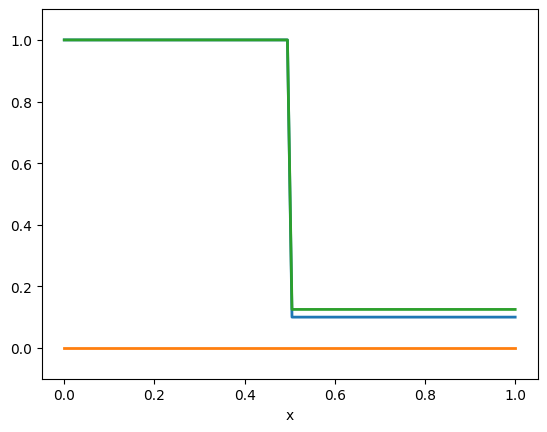

In [7]:
import math
# Boundary Condition
X_left_bc = list(itertools.product(t[1:],[0.0]))
X_right_bc = list(itertools.product(t[1:],[1.0]))


rho_left_bc = np.ones((nt-1))
rho_right_bc = np.full(shape=(nt-1), fill_value=0.1)

u_left_bc = np.zeros((nt-1))
u_right_bc = np.zeros((nt-1))

p_left_bc = np.ones((nt-1))
p_right_bc = np.full(shape=(nt-1), fill_value=0.125)


X_bc = np.concatenate((X_left_bc , X_right_bc))
rho_bc = np.concatenate((rho_left_bc , rho_right_bc))
u_bc = np.concatenate((u_left_bc , u_right_bc))
p_bc = np.concatenate((p_left_bc , p_right_bc))

#Initial Condition
X_initial = list(itertools.product([0.0],x))

rho_initial_temp1 = np.ones((int(nx/2)))
rho_initial_temp2 = np.full(shape=(int(nx/2)), fill_value=0.1)
rho_initial = np.concatenate((rho_initial_temp1 , rho_initial_temp2))

u_initial = np.zeros((nx))

p_initial_temp1 = np.ones((int(nx/2)))
p_initial_temp2 = np.full(shape=(int(nx/2)), fill_value=0.125)
p_initial = np.concatenate((p_initial_temp1 , p_initial_temp2))
print(x[11])
fig, result = plt.subplots()

result.plot(x, rho_initial, linewidth=2.0)
result.plot(x, u_initial, linewidth=2.0)
result.plot(x, p_initial, linewidth=2.0)

# plt.legend(["Density", "Velocity","pressure"], loc ="upper right")
plt.xlabel("x")
# plt.ylabel("u")
plt.ylim([-0.1,1.1])


Preparing training data and converting to Torch tensor

In [8]:
X_train = np.concatenate((X_initial , X_bc)).astype(np.float32)
rho_train = np.concatenate((rho_initial , rho_bc)).astype(np.float32)
u_train = np.concatenate((u_initial , u_bc)).astype(np.float32)
p_train = np.concatenate((p_initial , p_bc)).astype(np.float32)

X_train = torch.from_numpy(X_train).to(device)
rho_train = torch.from_numpy(rho_train).to(device)
u_train = torch.from_numpy(u_train).to(device)
p_train = torch.from_numpy(p_train).to(device)

Configuring PINN and its Optimizers

In [9]:
Layers = [2] + 4*[30] + [3]

PINet = NeuralNet(Layers)

optimizer1 = torch.optim.Adam(PINet.parameters() , lr = 1e-3)
optimizer2 = torch.optim.LBFGS(PINet.parameters() , lr = 1e-1)

scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer1 ,\
                                                        mode = 'min' ,\
                                                        patience = 120, \
                                                        factor = 0.8, \
                                                        threshold = 1e-5,\
                                                        verbose = True)

scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer2 ,\
                                                        mode = 'min' ,\
                                                        patience = 10, \
                                                        factor = 0.1, \
                                                        verbose = True)

Loss Function

In [10]:
loss_fn = torch.nn.MSELoss()

Closure Definition

In [11]:
def closure():
  optimizer.zero_grad()
  y_pred = PINet(X_train)

  IB_Loss = epsolin_1 * (loss_fn(y_pred[:,0] , rho_train) + loss_fn(y_pred[:,1] , u_train) + loss_fn(y_pred[:,2] , p_train))
  PDE_Loss = Euler_Equation_1D(PINet , X_colloc, gama, epsilon_2)
  total_loss = IB_Loss +  PDE_Loss


  global val_total_loss, val_IB_Loss, val_PDE_Loss

  val_total_loss = total_loss.item()
  val_IB_Loss = IB_Loss.item()
  val_PDE_Loss = PDE_Loss.item()
  total_loss.backward()

  return total_loss

Main Training Loop

In [12]:
import time
import matplotlib.pyplot as plt

No_epoch = np.array([Adam_it , LBFGS_it]) # Closure (Adams) , L-BFGS

start = time.time()

pointwise_Residual_values = [[] for i in range(int((Adam_it + LBFGS_it)/write_step))]
landa_Values = [[] for i in range(int((Adam_it + LBFGS_it)/write_step))]
total_loss_values = []
PDE_loss_values = []
IB_loss_values = []
epoch_values = []

for epoch in range(No_epoch.sum()):

  if epoch < No_epoch[0]:
    optimizer = optimizer1
    scheduler = scheduler1
  else:
    optimizer = optimizer2
    scheduler = scheduler2

  optimizer.step(closure)
  scheduler.step(val_total_loss)
  total_loss_values.append(val_total_loss)
  PDE_loss_values.append(val_PDE_Loss)
  IB_loss_values.append(val_IB_Loss)
  epoch_values.append(epoch)
  if(epoch%write_step == 0):
    i = int(epoch/write_step)
    pointwise_Residual_values[i] = pointwise_Residual.cpu().detach().numpy()
    # landa_Values[i] = landa[9602:9702].cpu().detach().numpy()
  if(epoch%10 == 0):
    elapsed = time.time() - start
    print("Epoch: ", epoch,"Total_Loss: ", val_total_loss,"IB_Loss:", val_IB_Loss, "PDE_Loss:", val_PDE_Loss, "Time = ", elapsed)
  if(epoch == (No_epoch.sum()-1)):
    print("Epoch: ", epoch,"Loss: ", val_total_loss, "Time = ", elapsed)

Epoch:  0 Total_Loss:  939.8746337890625 IB_Loss: 11.86618423461914 PDE_Loss: 928.0084228515625 Time =  0.27144908905029297
Epoch:  10 Total_Loss:  8.94077205657959 IB_Loss: 5.045299530029297 PDE_Loss: 3.895472288131714 Time =  1.4520139694213867
Epoch:  20 Total_Loss:  9.726491928100586 IB_Loss: 5.103035926818848 PDE_Loss: 4.623456001281738 Time =  2.621201515197754
Epoch:  30 Total_Loss:  6.907392501831055 IB_Loss: 4.87890625 PDE_Loss: 2.028486490249634 Time =  3.7665798664093018
Epoch:  40 Total_Loss:  6.532465934753418 IB_Loss: 4.476635932922363 PDE_Loss: 2.055830240249634 Time =  5.27308201789856
Epoch:  50 Total_Loss:  5.401114463806152 IB_Loss: 3.9994006156921387 PDE_Loss: 1.4017137289047241 Time =  7.3201744556427
Epoch:  60 Total_Loss:  4.645533561706543 IB_Loss: 3.529358386993408 PDE_Loss: 1.1161751747131348 Time =  8.707773685455322
Epoch:  70 Total_Loss:  4.001512050628662 IB_Loss: 3.1004233360290527 PDE_Loss: 0.9010886549949646 Time =  9.880486488342285
Epoch:  80 Total_Lo

Loss chart

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
X_test = torch.tensor(list(itertools.product(t,x)),dtype=torch.float32).to(device)

print(X_test[1500:1600])

y_pred = PINet(X_test)
y_pred = (y_pred).cpu().detach().numpy()

ax.plot(epoch_values, total_loss_values, linewidth=2.0)
ax.plot(epoch_values, PDE_loss_values, linewidth=2.0)
ax.plot(epoch_values, IB_loss_values, linewidth=2.0)

plt.xlabel("Epoch")
plt.ylabel("Loss value")
ax.set_yscale('log')
plt.legend(["total_loss", "PDE_loss","IB_loss"], loc ="upper right")
plt.ylim([1e-6, 10])

[Text(0.5, 0, 'x'), Text(0, 0.5, 'Residual')]

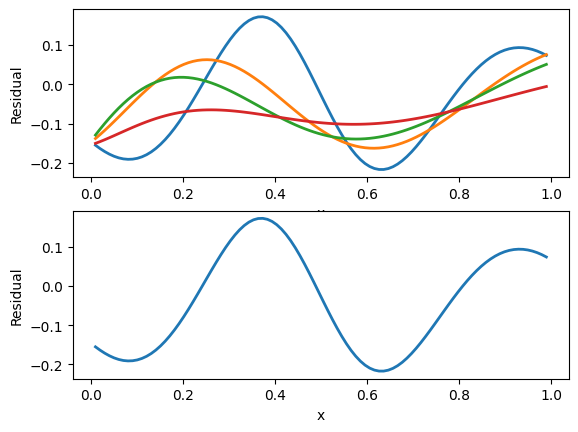

In [21]:
fig, axs = plt.subplots(2)

# axs[0].plot(x[1:-1], pointwise_Residual_values[5][864:882], linewidth=2.0)
axs[0].plot(x[1:-1], pointwise_Residual_values[4][1764:1862], linewidth=2.0)
axs[0].plot(x[1:-1], pointwise_Residual_values[3][1764:1862], linewidth=2.0)
axs[0].plot(x[1:-1], pointwise_Residual_values[2][1764:1862], linewidth=2.0)
axs[0].plot(x[1:-1], pointwise_Residual_values[1][1764:1862], linewidth=2.0)
# axs[0].legend(["it=20000", "it=15000","it=10000","it=5000"], loc ="lower right")
axs[0].set(xlabel='x', ylabel='Residual')

axs[1].plot(x[1:-1], pointwise_Residual_values[4][1764:1862], linewidth=2.0)
# axs[1].legend(["it=20000"], loc ="lower right")
axs[1].set(xlabel='x', ylabel='Residual')

# plt.ylim([-1, 2])

Text(0.5, 0, 'x')

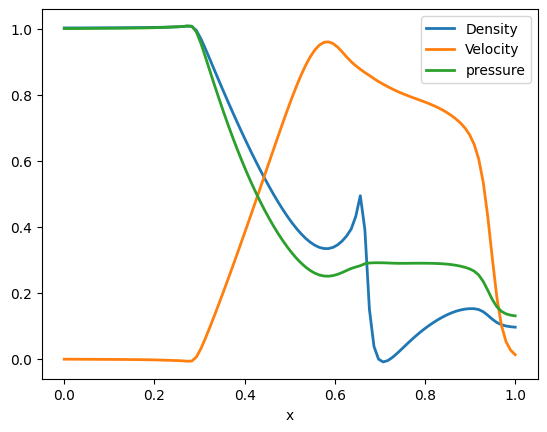

In [32]:
fig, result = plt.subplots()

result.plot(x, y_pred[1900:2000,0], linewidth=2.0)
result.plot(x, y_pred[1900:2000,1], linewidth=2.0)
result.plot(x, y_pred[1900:2000,2], linewidth=2.0)

plt.legend(["Density", "Velocity","pressure"], loc ="upper right")
plt.xlabel("x")
# plt.ylabel("u")
# plt.ylim([-0.5,1.2])

ValueError: ignored

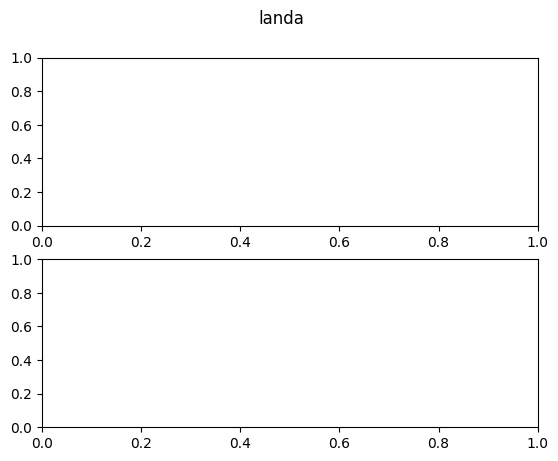

In [ ]:
fig, axs = plt.subplots(2)
fig.suptitle('landa')

axs[0].plot(x[1:-1], landa_Values[4][864:912], linewidth=2.0)
axs[0].plot(x, landa_Values[3], linewidth=2.0)
axs[0].plot(x, landa_Values[2], linewidth=2.0)
axs[0].plot(x, landa_Values[1], linewidth=2.0)
axs[0].plot(x, landa_Values[0], linewidth=2.0)
axs[0].legend(["it=20000", "it=15000","it=10000","it=5000"], loc ="lower right")
axs[0].set(xlabel='x', ylabel='landa')

axs[1].plot(x, landa_Values[4], linewidth=2.0)
axs[1].legend(["it=20000"], loc ="lower right")
axs[1].set(xlabel='x', ylabel='landa')

plt.ylim([0, 1.2])

[Text(0.5, 0, 'x'), Text(0, 0.5, 'landa')]

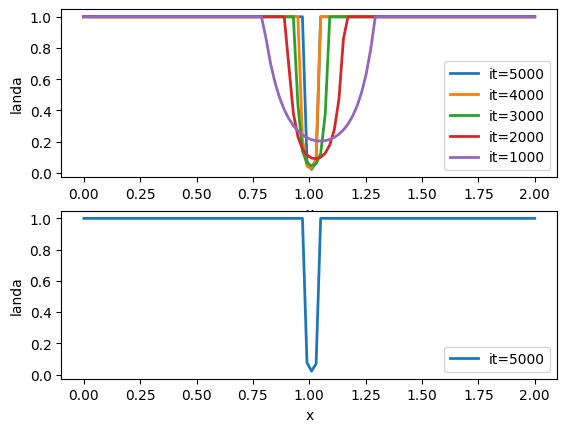

In [ ]:
fig, axs = plt.subplots(2)
# fig.suptitle('landa')

axs[0].plot(x, landa_Values[Adam_it-1][9602:9702], linewidth=2.0)
axs[0].plot(x, landa_Values[4000][9602:9702], linewidth=2.0)
axs[0].plot(x, landa_Values[3000][9602:9702], linewidth=2.0)
axs[0].plot(x, landa_Values[2000][9602:9702], linewidth=2.0)
axs[0].plot(x, landa_Values[1000][9602:9702], linewidth=2.0)
axs[0].legend(["it=5000", "it=4000","it=3000","it=2000","it=1000"], loc ="lower right")
axs[0].set(xlabel='x', ylabel='landa')

axs[1].plot(x, landa_Values[Adam_it-1][9602:9702], linewidth=2.0)
axs[1].legend(["it=5000"], loc ="lower right")
axs[1].set(xlabel='x', ylabel='landa')

# plt.show()

In [ ]:
U_vanillaPINN_Withoutany_Coeff = []
U_vanillaPINN_Withoutany_Coeff = u_pred[9602:9702]

In [ ]:
U_vanillaPINN_Withoutany_epsilon1_01 = []
U_vanillaPINN_Withoutany_epsilon1_01 = u_pred[9602:9702]

In [ ]:
U_vanillaPINN_Withoutany_epsilon1_001 = []
U_vanillaPINN_Withoutany_epsilon1_001 = u_pred[9602:9702]

In [ ]:
U_vanillaPINN_Withoutany_epsilon1_0001 = []
U_vanillaPINN_Withoutany_epsilon1_0001 = u_pred[9602:9702]

(-0.8, 0.8)

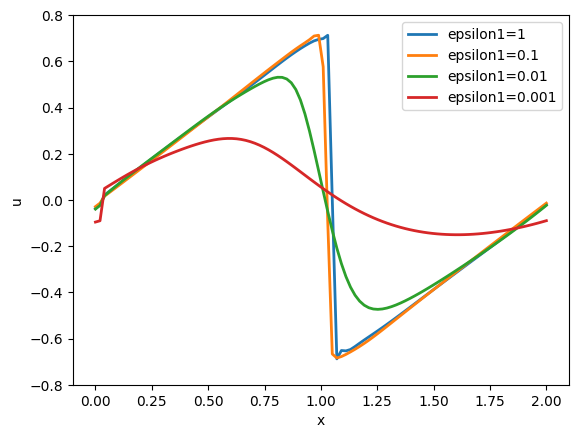

In [ ]:
fig, p = plt.subplots()
p.plot(x, U_vanillaPINN_Withoutany_Coeff, linewidth=2.0)
p.plot(x, U_vanillaPINN_Withoutany_epsilon1_01, linewidth=2.0)
p.plot(x, U_vanillaPINN_Withoutany_epsilon1_001, linewidth=2.0)
p.plot(x, U_vanillaPINN_Withoutany_epsilon1_0001, linewidth=2.0)
#print(P_pred)
plt.xlabel("x")
plt.ylabel("u")
plt.legend(["epsilon1=1", "epsilon1=0.1","epsilon1=0.01","epsilon1=0.001"], loc ="upper right")
plt.ylim([-0.8,0.8])

In [ ]:
U_WEPINN_epsilon1_01_epsilon2_1 = []
U_WEPINN_epsilon1_01_epsilon2_1 = u_pred[9602:9702]

In [ ]:
U_WEPINN_epsilon1_01_epsilon2_01 = []
U_WEPINN_epsilon1_01_epsilon2_01 = u_pred[9602:9702]

In [ ]:
U_WEPINN_epsilon1_01_epsilon2_001 = []
U_WEPINN_epsilon1_01_epsilon2_001 = u_pred[9602:9702]

(-0.8, 0.8)

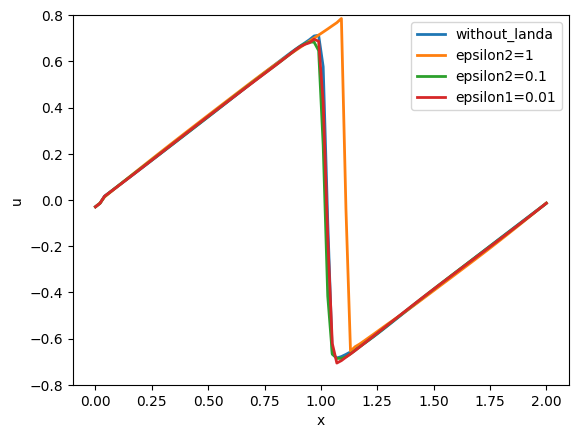

In [ ]:
fig, p = plt.subplots()

p.plot(x, U_vanillaPINN_Withoutany_epsilon1_01, linewidth=2.0)
p.plot(x, U_WEPINN_epsilon1_01_epsilon2_1, linewidth=2.0)
p.plot(x, U_WEPINN_epsilon1_01_epsilon2_01, linewidth=2.0)
p.plot(x, U_WEPINN_epsilon1_01_epsilon2_001, linewidth=2.0)

#print(P_pred)
plt.xlabel("x")
plt.ylabel("u")
plt.legend(["without_landa", "epsilon2=1","epsilon2=0.1","epsilon1=0.01"], loc ="upper right")
plt.ylim([-0.8,0.8])